In [2]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [4]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1))) 
        # stack a matrix and a column
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
            # finds the least square solution to a linear system: W*XI=y
            # n >= d: close-form exists
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            # (X^T X + \epsilon)^(-1) X^T y
            # n < d: only approximation exists
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
            # least square solution
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [5]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [29]:
# Sub-Problem 1
# TODO: coordinate descent of lasso, note lmda stands for lambda
import time
def F(XI, y, W, lmda):
    diff = np.matmul(XI, W) - y
    loss = 0.5 * np.matmul(diff.T, diff) + lmda * np.sum(np.abs(W[:-1]))
    return loss

def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    w, w0 = Initialw(X, y)
    n, d = X.shape
    W = np.hstack((w, w0))
    XI = np.hstack((X, np.ones(n).reshape(n,1)))
    iterations = []
    losses = []
    for i in range(max_iter):
        tmp = np.copy(W)
        last = time.time()
        for j in range(d + 1):
            mask = np.hstack((np.arange(j), np.arange(j + 1, d + 1)))
            #print(mask)
            r = y - np.matmul(XI[:, mask], W[mask])
            a = np.dot(XI[:, j].T, XI[:, j])
            c = np.dot(r, XI[:, j])
            last = W[j]
            if c < -lmda:
                W[j] = (c + lmda) / a
            elif c > lmda:
                W[j] = (c - lmda) / a
            else:
                W[j] = 0
        iterations.append(i + 1)
        loss = F(XI, y, W, lmda)
        losses.append(loss)
        if (np.abs(W - tmp) <= epsilon).all():
            #print(i)
            break
        print(last)
        if i > 1:
            break
    if draw_curve:
        plt.plot(iterations, losses)
        plt.xlabel('iterations')
        plt.ylabel('F(theta)')
        #plt.savefig('figs/2.1.pdf')
        plt.show()
    w, w0 = W[:d], W[d]
    return (w, w0)

In [6]:
# Sub-Problem 1: data generation
n = 100
m = 150

X, y, w_true, w0_true = DataGenerator(n=n, d=m, k=5, sigma=1.0, w0=0.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

[[ 0.10430293 -0.55011253 -0.07271465 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ... -0.50546019 -0.04159342
  -0.01291595]
 [ 0.31860678  0.09803393  0.79127714 ...  0.84931761 -0.42616459
   0.76857532]
 ...
 [ 0.55546365  0.84917102 -0.82208175 ... -2.03365761  0.28594759
   0.30328844]
 [-0.31075096  0.86697979 -0.2050817  ...  0.132073   -1.3469008
  -0.29268038]
 [ 2.51943233  1.03025557 -0.30999576 ... -2.86031678 -0.43470702
   1.70951079]]
[-7.93452268e+00 -6.87566861e+00  5.68374639e-02 -1.94470223e+01
  1.87131844e+01  4.20497625e+01  6.90698646e+00  2.03785690e+01
  1.78108400e+01  4.65235311e+00  2.63299434e+01 -1.90828279e+01
  3.02355009e+01 -3.04834891e+00  2.90505728e+01 -7.77200894e+00
 -1.93982280e+01 -2.77393652e+00  5.07843132e+00  2.23407469e+01
 -1.34518275e+01  1.11170455e+01 -9.41918304e+00 -3.00534897e+01
 -1.51874463e+01 -3.05091015e+01 -1.63346731e+01  2.72735794e+00
 -1.68427630e+01 -2.30655049e+01 -2.30117919e+01 -1.04

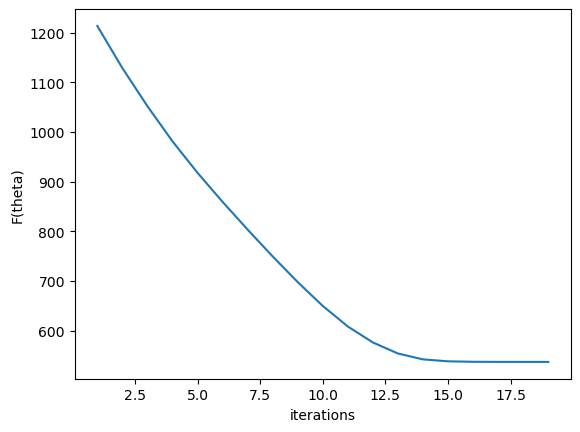

[ 1.00585568e+01  9.64936274e+00 -9.84619755e+00 -9.75179575e+00
  1.00053133e+01 -8.17652886e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.28577986e-02
  0.00000000e+00  0.00000000e+00  4.31362255e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.34598325e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.23757119e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.95527620e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.18464847e-02  0.00000000e+00
 -1.61033321e-02  0.00000000e+00 -4.45354698e-02 -1.01744159e-02
  0.00000000e+00 -4.57422227e-03  0.00000000e+00  0.00000000e+00
 -4.62366381e-02  1.58481

In [7]:
# Sub-Problem 1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
print(w0_lasso)
print([i for i in range(len(w_lasso)) if np.abs(w_lasso[i]) > 1.1e-1])
print([i for i in range(len(w_true)) if w_true[i] != 0])

In [8]:
# Sub-Problem 2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    non_zero = set([i for i in range(len(w)) if w[i] != 0])
    non_zero_true = set([i for i in range(len(w_true)) if w_true[i] != 0])
    intersection = non_zero.intersection(non_zero_true)
    if len(non_zero) > 0:
        precision_w = len(intersection) / len(non_zero)
    else:
        precision_w = 1
    if len(non_zero_true) > 0:
        recall_w = len(intersection) / len(non_zero_true)
    else:
        precision_w = 1

    sparsity_w = len(non_zero)

    n = X.shape[0]
    y_hat = np.matmul(X, w) + w0
    diff = y_hat - y
    rmse = np.sqrt(np.dot(diff.T, diff) / n)
    return (rmse, sparsity_w, precision_w, recall_w)

In [9]:
# Sub-Problem 2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print('rmse={}'.format(Emetric[0]))
print('sparsity={}'.format(Emetric[1]))
print('precision={}'.format(Emetric[2]))
print('recall={}'.format(Emetric[3]))

rmse=0.7786786147832326
sparsity=38
precision=0.13157894736842105
recall=1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


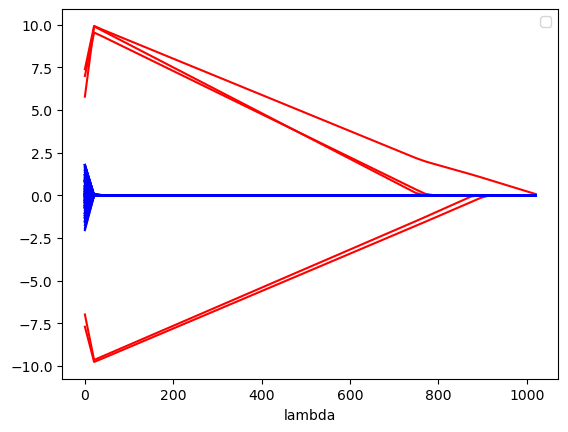

(array([[ 7.39373446,  9.92860197,  9.69049289, ...,  0.40291899,
          0.23761632,  0.07231364],
        [ 6.99530278,  9.54022446,  9.28989862, ...,  0.        ,
          0.        ,  0.        ],
        [-7.69734486, -9.76173597, -9.54018449, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.0448842 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.72133547,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.25481499,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([0.5491373, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [10]:
# Sub-Problem 3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    num_lmda = 50
    W = np.zeros((X.shape[1], num_lmda))
    W0 = np.zeros(num_lmda)

    y_diff = (y - np.mean(y)).reshape(y.shape[0], -1)
    #lmda_max = np.max(np.matmul(y_diff.T, X))
    lmda_max = np.max(np.abs((y - np.mean(y)).dot(X)))
    lmda_min = 0
    Lmda = np.linspace(lmda_min, lmda_max, num = num_lmda)

    for idx, lmda in enumerate(Lmda):
        w_lasso, w0_lasso = lasso(
            X, y, 
            lmda = lmda, epsilon = 1.0e-2,
            draw_curve = False, max_iter = 100)
        W[:, idx] = w_lasso
        W0[idx] = w0_lasso

    for i in range(X.shape[1]):
        if w_true[i] != 0: 
            plt.plot(Lmda, W[i, :], c = 'r')
        else:
            plt.plot(Lmda, W[i, :], c = 'b')
    if w0_true != 0:
        plt.plot(W0, c = 'r')
    else:
        plt.plot(W0, c = 'b')
    plt.legend()
    plt.xlabel('lambda')
    #plt.savefig('figs/2.3.2n={}m={}.pdf'.format(n, m))
    plt.show()

    return (W, W0, Lmda)

LassoPath(X, y)

In [11]:
# Sub-Problem 3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda, draw_curve = False):
    #########TODO##########
    RMSE = []
    Sparsity = []
    Precision = []
    Recall = []
    for i in range(len(W0)):
        w = W[:, i]
        w0 =W0[i]
        emetric = Evaluate(X, y, w, w0, w_true, w0_true)
        RMSE.append(emetric[0])
        Sparsity.append(emetric[1])
        Precision.append(emetric[2])
        Recall.append(emetric[3])
    if draw_curve:
        plt.plot(Lmda, Precision)
        plt.plot(Lmda, Recall)
        plt.xlabel('lambda')
        plt.legend(['precision', 'recall'])
        #plt.savefig('figs/2.3.1n={}m={}.pdf'.format(n, m))
        plt.show()
    return (RMSE, Sparsity, Precision, Recall)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


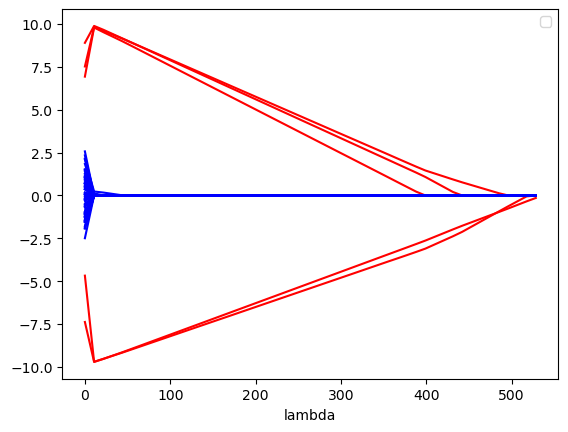

(array([[ 7.51844778,  9.8130805 ,  9.60174094, ...,  0.        ,
          0.        ,  0.        ],
        [-4.67416969, -9.6959014 , -9.5239019 , ..., -0.34237055,
         -0.05408887,  0.        ],
        [-7.37606445, -9.70415134, -9.53067957, ..., -0.5516847 ,
         -0.34372747, -0.14621087],
        ...,
        [ 0.60685953,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.40377226,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.21314915,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([-1.52379843,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        

In [12]:
# Sub-Problem 3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
LassoPath(X, y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


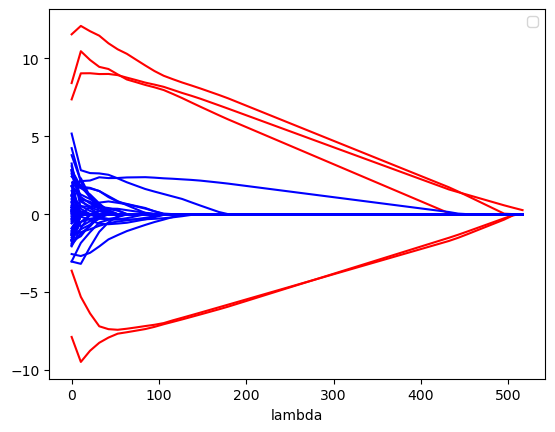

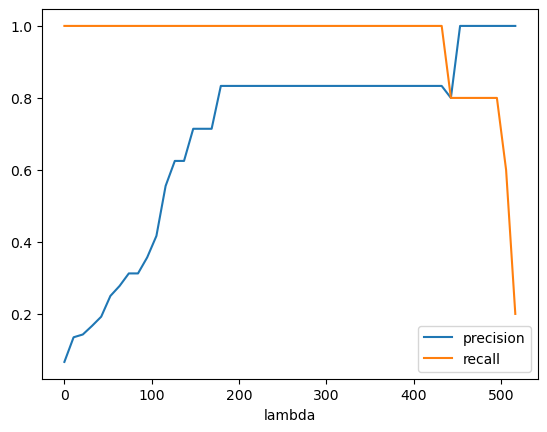

([0.0005311643105887639,
  2.223618566786262,
  3.5806318040980547,
  4.8108032675922985,
  5.686498083291025,
  6.33190914671094,
  6.898205506601841,
  7.379597146961897,
  7.896477080115198,
  8.368322523843387,
  8.808582941793276,
  9.184623513246045,
  9.55689844176189,
  9.912825999822116,
  10.280409578306662,
  10.657099120012736,
  11.045593377399808,
  11.429068080937878,
  11.790157480884739,
  12.160228188948855,
  12.538484729289529,
  12.924207966258894,
  13.316748681818042,
  13.715521709196524,
  14.119997845000533,
  14.529701494355209,
  14.94427844573698,
  15.363172799971968,
  15.786133058168225,
  16.212835603709067,
  16.642991264506293,
  17.07633908900853,
  17.512642109915916,
  17.951684856637584,
  18.393271140525652,
  18.837222083964182,
  19.283377482783237,
  19.731524242702214,
  20.181591236328995,
  20.633447824376123,
  21.086978963646885,
  21.54207889007871,
  21.945749631605004,
  22.318172594585,
  22.685725821199338,
  23.05566404398365,
  23.

In [13]:
# Sub-Problem 3
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
(W, W0, Lmda) = LassoPath(X, y)
EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda, draw_curve = True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


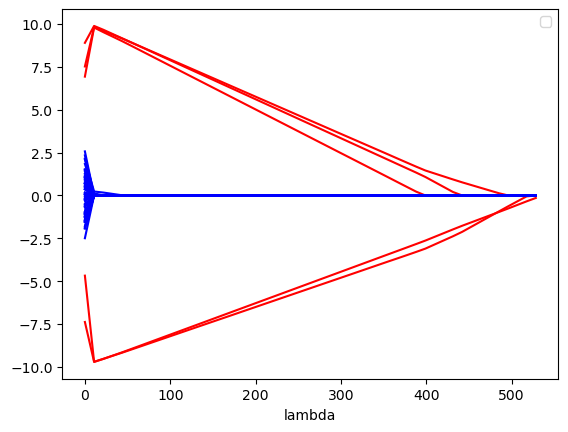

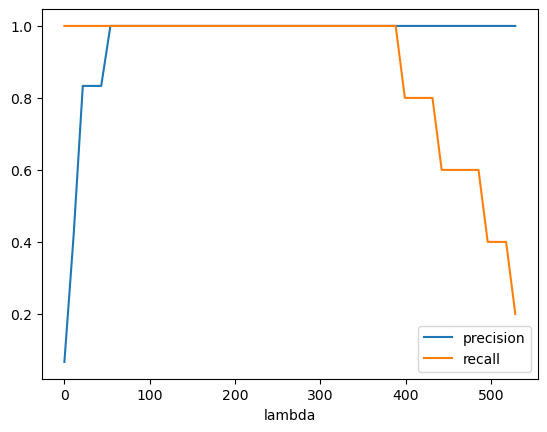

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


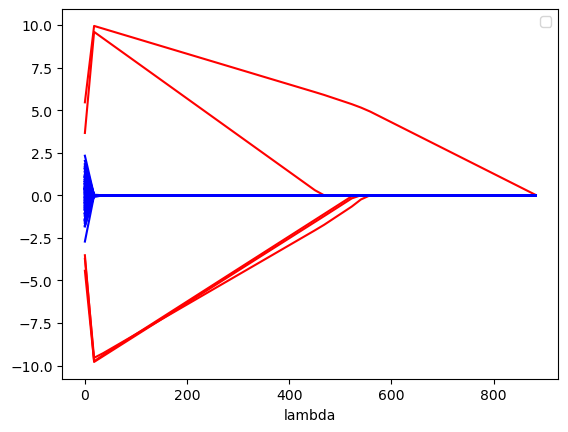

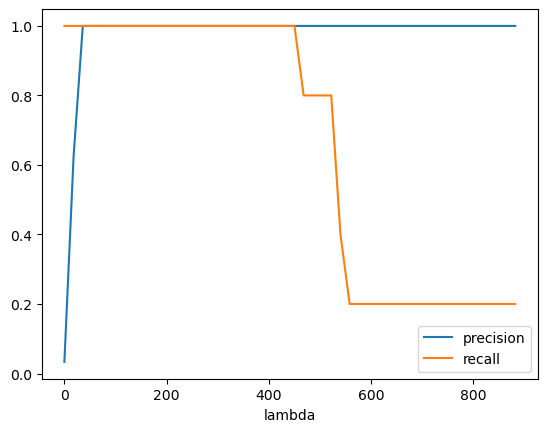

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


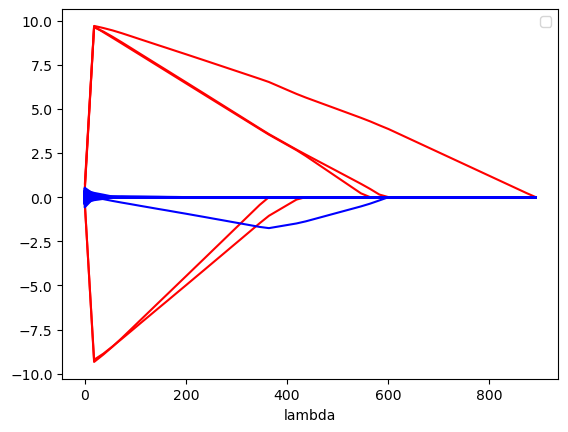

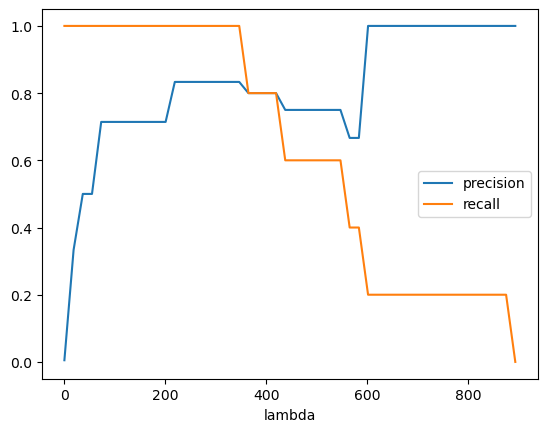

/state/partition1/job-44722621/ipykernel_4150132/2660250358.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


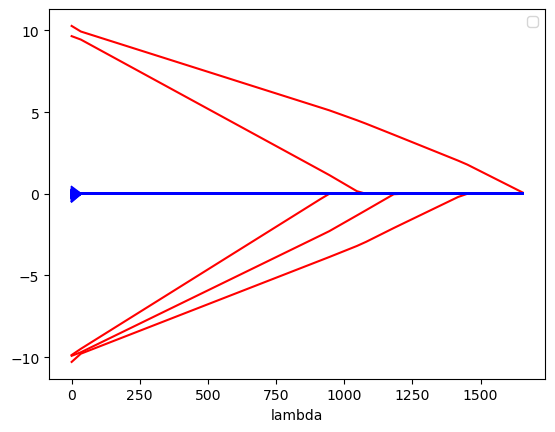

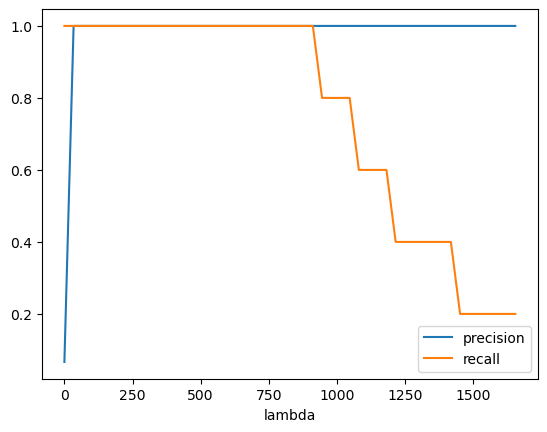

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


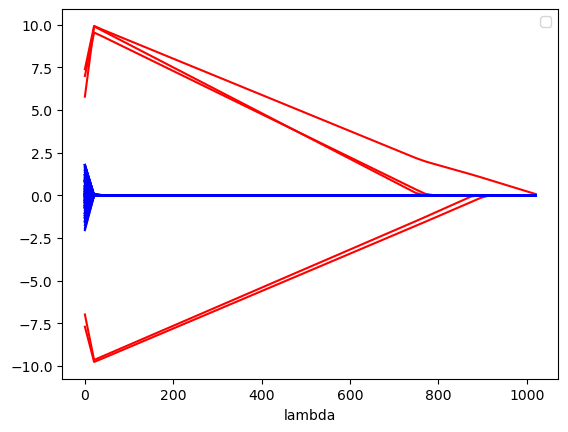

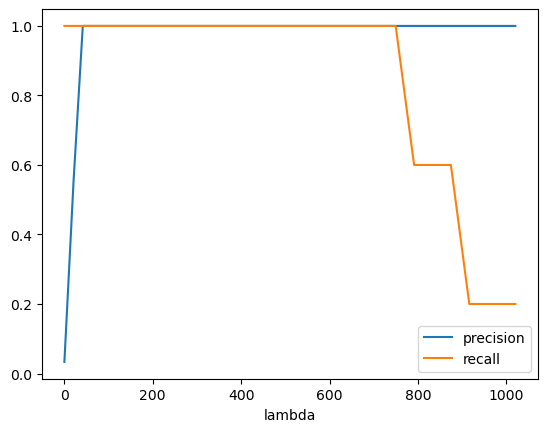

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


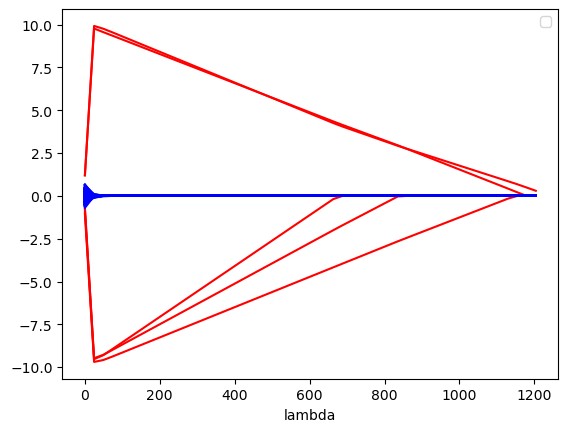

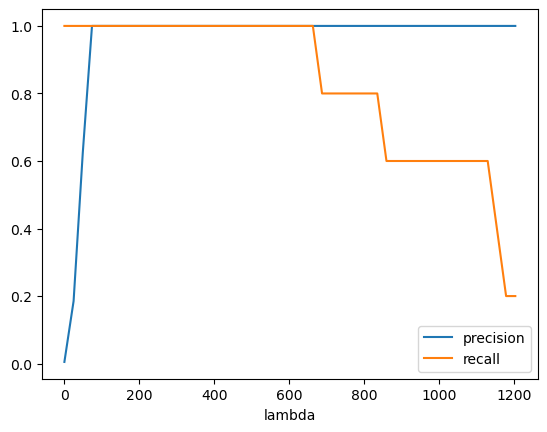

In [14]:
# Sub-Problem 4
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
for n in [50, 100]:
    for m in [75, 150, 1000]:
        X, y, w_true, w0_true = DataGenerator(n=n, d=m, k=5, sigma=1.0)
        (W, W0, Lmda) = LassoPath(X, y)
        EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda, draw_curve = True)
        

In [6]:
# Sub-Problem 5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int32)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [26]:
# Sub-Problem 5: training of sparse-lasso regression
# TODO
from tqdm import tqdm
def sparse_lasso(X_train, y_train, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100):
    w, w0 = Initialw(X_train, y_train)
    W, W0 = [], []
    n, d = X_train.shape
    iterations = []
    losses = []
    for i in tqdm(range(max_iter)):
        tmp = w.copy()
        last = time.time()
        for j in range(d):
            r = y_train.reshape(-1, 1) - X_train.dot(w).reshape(-1, 1) + X_train[:, j].dot(w[j]) - w0
            a = ((X_train[:, j]).multiply(X_train[:, j])).sum(axis = 0)
            c = (X_train[:, j].multiply(r)).sum(axis = 0)
            if c < -lmda:
                w[j] = (c + lmda) / a[0][0]
            elif c > lmda:
                w[j] = (c - lmda) / a[0][0]
            else:
                w[j] = 0
        iterations.append(i + 1)

        w0 = y_train.mean(axis = 0) - X_train.dot(w).mean(axis = 0)
        error = X_train.dot(w) + w0 - y_train
        loss = 0.5 * np.multiply(error, error).sum(axis = 0) + lmda * (np.abs(w)).sum(axis = 0)
        losses.append(loss)

        W.append(w.copy())
        W0.append(w0.copy())
        
        if (np.abs(w - tmp).max() <= epsilon):
            #print(i)
            break
        print(time.time()-last)
        break
    return w, w0, W, W0

In [8]:
def sparse_eval(X, y, w, w0):
    n = X.shape[0]
    y_hat = X.dot(w) + w0
    y_diff = y_hat - y
    rmse = np.sqrt(y_diff.T.dot(y_diff) / n)
    return rmse

In [9]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    n, d = X_train.shape
    y_diff = y_train - np.mean(y_train)
    y_diff = sparse.csc_array(y_diff)
    lmda_max = np.abs(y_diff.dot(X_train)).max()
    lmda_min = 0.1 * lmda_max
    Lmda = np.linspace(lmda_max, lmda_min, num = 20)

    rmse_min = 100
    train_RMSE = []
    valid_RMSE = []

    for lmda in Lmda:
        print('lambda = {}'.format(lmda))
        w, w0, W, W0 = sparse_lasso(X_train, y_train, lmda = lmda, max_iter = 100)
        W = np.array(W)

        train_rmse = sparse_eval(X_train, y_train, w, w0)
        valid_rmse = sparse_eval(X_valid, y_valid, w, w0)
        print('train rmse = {} | valid rmse = {}'.format(train_rmse, valid_rmse))
        
        train_RMSE.append(train_rmse)
        valid_RMSE.append(valid_rmse)
        if valid_rmse < rmse_min:
            rmse_min = valid_rmse
            lmda_best = lmda
            w_lasso = w
            w0_lasso = w0

        for i in range(W.shape[1]):
            plt.plot(np.arange(1, W.shape[0] + 1), W[:, i], c = 'r')

    plt.xlabel('lmda')
    plt.ylabel('theta')
    plt.savefig('LassoPath.pdf')
    plt.show()
    
        
    plt.plot(Lmda, train_RMSE)
    plt.plot(Lmda, valid_RMSE)
    plt.xlabel('lmda')
    plt.ylabel('RMSE')
    plt.legend(['train', 'valid'])
    plt.savefig('Rmse.pdf')
    plt.show()
    
    return (w_lasso, w0_lasso, lmda_best)

loading data...
(30000, 2500) (30000,) (5000, 2500) (5000,) (10000, 2500) (10000,)
Evaluating...
lambda = 39.57825401364829


  0%|          | 0/100 [00:00<?, ?it/s]/state/partition1/job-44742632/ipykernel_1379470/2897458083.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[j] = (c + lmda) / a[0][0]
/state/partition1/job-44742632/ipykernel_1379470/2897458083.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[j] = (c - lmda) / a[0][0]
  6%|▌         | 6/100 [00:41<10:54,  6.96s/it]


train rmse = 1.220158528084328 | valid rmse = 1.2141997302944822
lambda = 37.703494613001794


  6%|▌         | 6/100 [00:42<11:06,  7.09s/it]


train rmse = 1.2181790374491166 | valid rmse = 1.2123237425157025
lambda = 35.8287352123553


  7%|▋         | 7/100 [00:47<10:36,  6.84s/it]


train rmse = 1.216293287091708 | valid rmse = 1.210534792403476
lambda = 33.953975811708794


  7%|▋         | 7/100 [00:47<10:31,  6.79s/it]


train rmse = 1.2144992910472765 | valid rmse = 1.2088309667459503
lambda = 32.0792164110623


  8%|▊         | 8/100 [00:53<10:12,  6.65s/it]


train rmse = 1.2119171286848727 | valid rmse = 1.2063051278690768
lambda = 30.2044570104158


  9%|▉         | 9/100 [00:59<10:04,  6.64s/it]


train rmse = 1.2075321438818456 | valid rmse = 1.2020438683759935
lambda = 28.329697609769305


 10%|█         | 10/100 [01:05<09:48,  6.54s/it]


train rmse = 1.2022449538143072 | valid rmse = 1.1971464228111517
lambda = 26.454938209122805


 10%|█         | 10/100 [01:05<09:47,  6.53s/it]


train rmse = 1.1943643835476876 | valid rmse = 1.1896450747571206
lambda = 24.580178808476305


 12%|█▏        | 12/100 [01:16<09:19,  6.36s/it]


train rmse = 1.1842531921815693 | valid rmse = 1.1796614554407594
lambda = 22.705419407829808


 22%|██▏       | 22/100 [02:15<07:58,  6.14s/it]


train rmse = 1.1727361620534462 | valid rmse = 1.1682446583999775
lambda = 20.83066000718331


 23%|██▎       | 23/100 [02:21<07:53,  6.15s/it]


train rmse = 1.1609201359771728 | valid rmse = 1.1563368531661815
lambda = 18.95590060653681


 24%|██▍       | 24/100 [02:27<07:45,  6.13s/it]


train rmse = 1.148664733928351 | valid rmse = 1.1440474682433444
lambda = 17.081141205890315


 24%|██▍       | 24/100 [02:27<07:46,  6.14s/it]


train rmse = 1.1349789224907136 | valid rmse = 1.1297825314935697
lambda = 15.206381805243815


 24%|██▍       | 24/100 [02:27<07:45,  6.13s/it]


train rmse = 1.1196275506208717 | valid rmse = 1.1137054316125727
lambda = 13.331622404597319


 25%|██▌       | 25/100 [02:33<07:40,  6.15s/it]


train rmse = 1.103003196217105 | valid rmse = 1.0963469352716162
lambda = 11.456863003950819


 27%|██▋       | 27/100 [02:44<07:25,  6.10s/it]


train rmse = 1.086060478831146 | valid rmse = 1.07893283422818
lambda = 9.582103603304322


 30%|███       | 30/100 [03:02<07:06,  6.09s/it]


train rmse = 1.0683175797622877 | valid rmse = 1.061084987711629
lambda = 7.707344202657826


 30%|███       | 30/100 [03:02<07:05,  6.08s/it]


train rmse = 1.0504325600089506 | valid rmse = 1.0431721173769315
lambda = 5.832584802011326


 43%|████▎     | 43/100 [04:09<05:30,  5.80s/it]


train rmse = 1.0324709773593381 | valid rmse = 1.0258572586202535
lambda = 3.957825401364829


 65%|██████▌   | 65/100 [06:05<03:16,  5.62s/it]


train rmse = 1.0134319486297443 | valid rmse = 1.0096506956531799


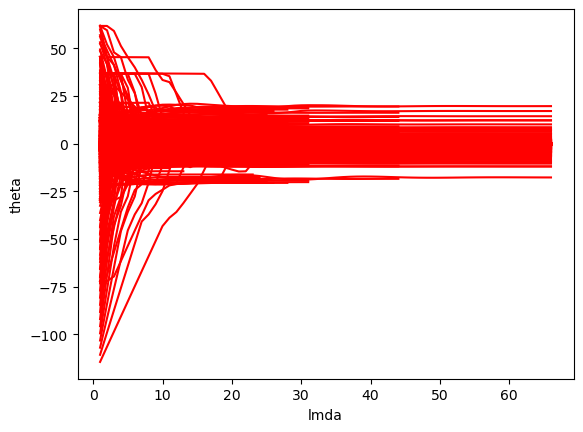

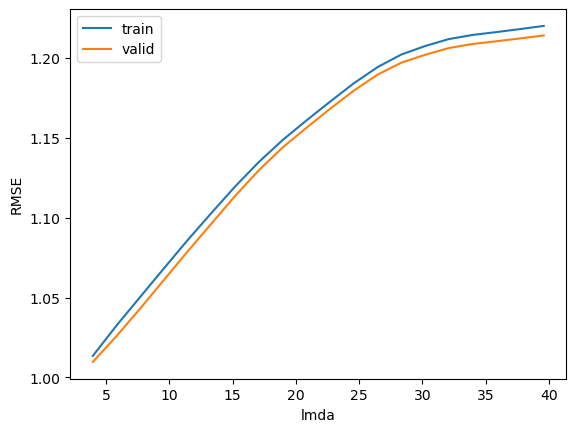

Lasso select features:
great 19.627039766033455
not -17.74656486191608
best 17.057275832222444
amazing 14.339594761501568
love 12.228605562854616
delicious 12.1324175630963
rude -11.989835404969925
the worst -11.959623046998004
horrible -10.486131687632195
awesome 10.058487720144088


In [10]:
# Sub-Problem 5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
import numpy as np
from scipy.sparse.linalg import lsqr
print('loading data...')
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('data/star_data.mtx', 'data/star_labels.txt', 'data/star_features.txt', 30000, 5000)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
#print(X_test)

# evaluation
print('Evaluating...')
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])

In [11]:
print(lmda_best)

3.957825401364829


In [12]:
test_rmse = sparse_eval(X_test, y_test, w_lasso, w0_lasso)
print(test_rmse)

1.0252433500953926


In [15]:
sparse_lasso(X_train, y_train)
sparse_lasso(X_valid, y_valid)
sparse_lasso(X_test, y_test)

  0%|          | 0/100 [00:00<?, ?it/s]/state/partition1/job-44742632/ipykernel_1379470/3236350738.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[j] = (c - lmda) / a[0][0]
/state/partition1/job-44742632/ipykernel_1379470/3236350738.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[j] = (c + lmda) / a[0][0]
  0%|          | 0/100 [00:05<?, ?it/s]

5.598681926727295



  0%|          | 0/100 [00:02<?, ?it/s]

2.330958843231201



  0%|          | 0/100 [00:02<?, ?it/s]

2.9963417053222656


(array([0., 0., 0., ..., 0., 0., 0.]),
 3.8515432838654062,
 [array([0., 0., 0., ..., 0., 0., 0.])],
 [3.8515432838654062])

In [33]:
#print(X_train.shape)
#print(y_train.shape)
#lasso(X_train, y_train)
X, y = DataGenerator(n=3, d=75, k=5, sigma=1.0)
lasso(X, y)

(30000, 2500)
(30000,)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)